In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import Module, Conv2d, Linear, MaxPool2d, ReLU, LogSoftmax
from torch import flatten
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
import os
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from PIL import Image
from torch.utils.data import DataLoader, random_split

In [88]:
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.utils import shuffle
from os import listdir
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score

In [89]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray_blurred, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

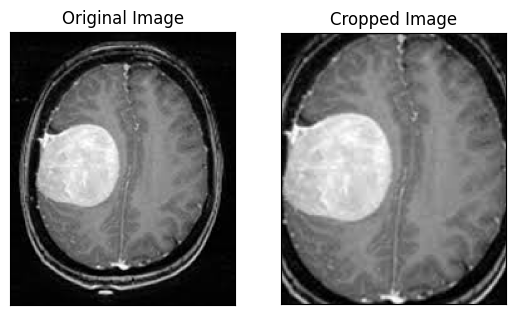

In [90]:
ex_img = cv2.imread('C:/Users/aytem/Desktop/testgit/5820-Final-Project/data/yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [91]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [92]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # crop the brain and ignore the unnecessary rest part of the image
            image = cv2.imread(directory + '\\' + filename)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [93]:
augmented_path = 'C:/Users/aytem/Desktop/testgit/5820-Final-Project/data'

# augmented data (yes and no) contains both the original and the new generated examples
data_yes = augmented_path + '/yes' 
data_no = augmented_path + '/no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([data_yes, data_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 253
X shape is: (253, 240, 240, 3)
y shape is: (253, 1)


In [94]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

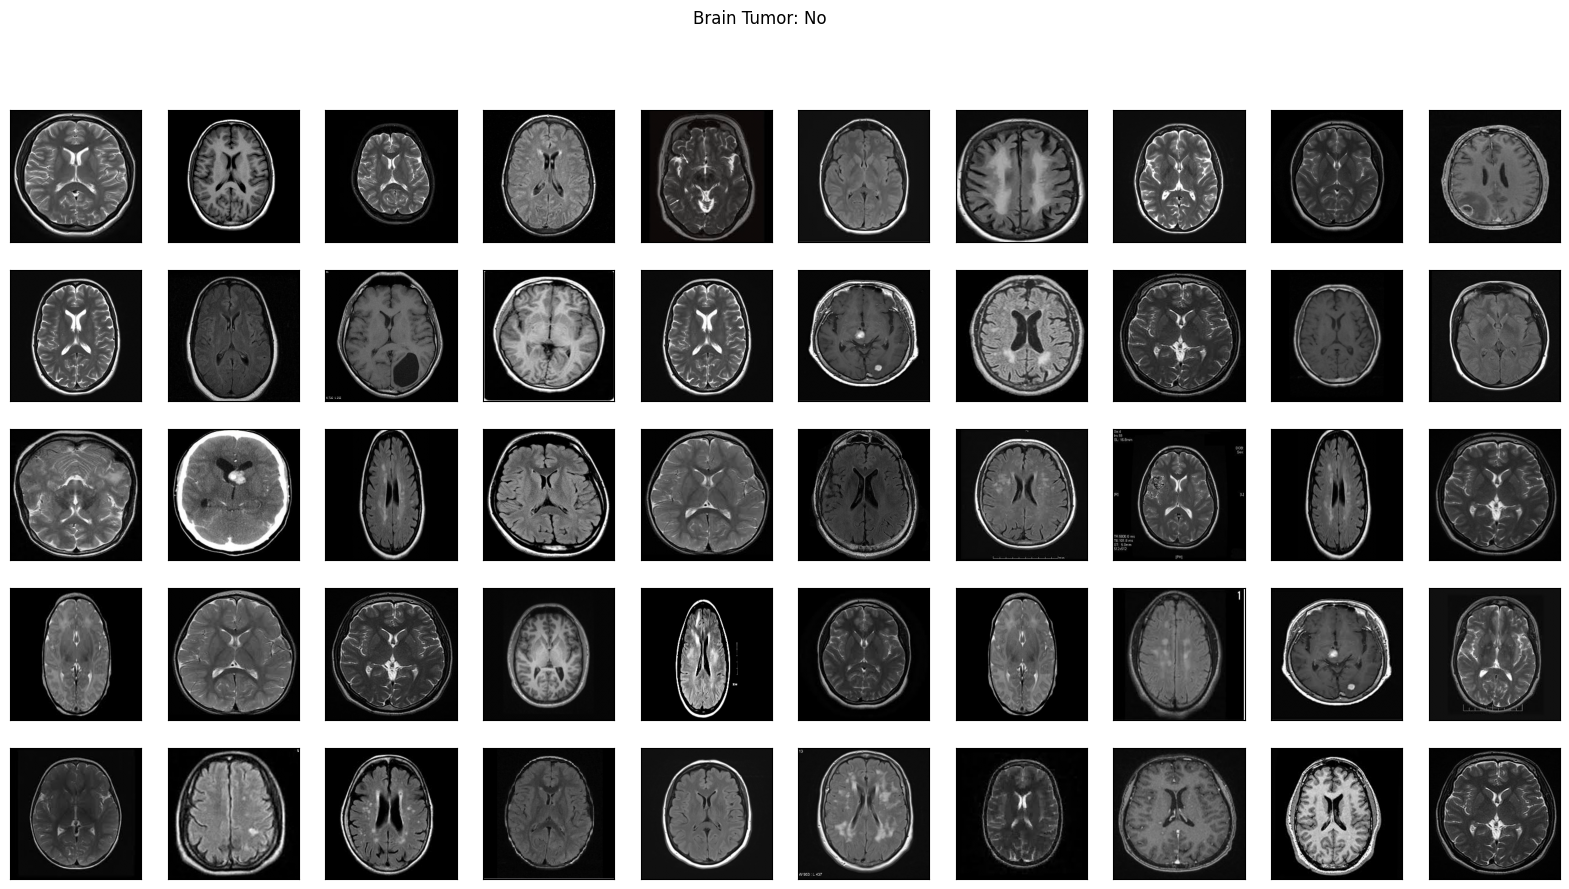

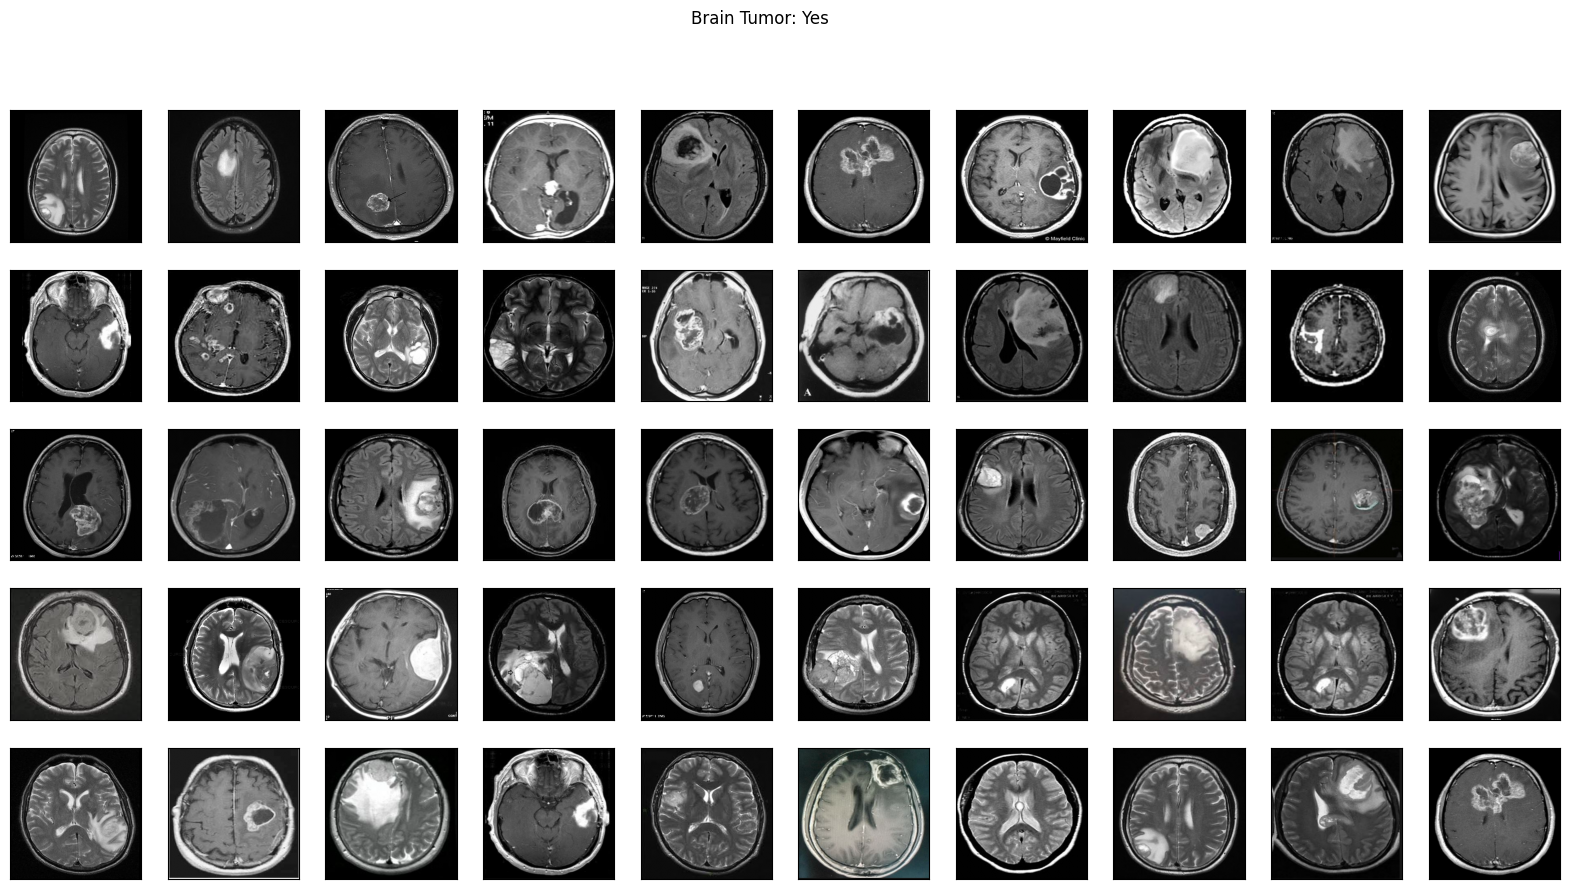

In [95]:
plot_sample_images(X, y)

In [96]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [97]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [98]:
import torch.utils
import torch.utils.data

training_loader = torch.utils.data.DataLoader(X_train, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(X_val, batch_size=4, shuffle=False)

In [99]:
print('Training set has {} instances'.format(len(X_train)))
print('Validation set has {} instances'.format(len(X_val)))

Training set has 177 instances
Validation set has 38 instances


In [100]:
IMG_SHAPE = (240, 240, 3) 

In [101]:
class BrainDetectionModel(nn.Module):
    def __init__(self, input_shape):
        super(BrainDetectionModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_shape[2], out_channels=32, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(4, 4))
        self.pool2 = nn.MaxPool2d(kernel_size=(4, 4))
        self.fc1 = nn.Linear(6272, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x

model = BrainDetectionModel(IMG_SHAPE)


In [102]:
from torchsummary import summary
summary(model, input_size=IMG_SHAPE)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            4,736
├─BatchNorm2d: 1-2                       64
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─MaxPool2d: 1-5                         --
├─Linear: 1-6                            6,273
├─Sigmoid: 1-7                           --
Total params: 11,073
Trainable params: 11,073
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            4,736
├─BatchNorm2d: 1-2                       64
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─MaxPool2d: 1-5                         --
├─Linear: 1-6                            6,273
├─Sigmoid: 1-7                           --
Total params: 11,073
Trainable params: 11,073
Non-trainable params: 0

In [111]:
import tqdm
import copy
def train_dataset(model, X_train, y_train, X_val, y_val):
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.BCELoss()

    num_epochs = 250
    batch_size = 10
    batch_start = torch.arange(0, len(X_train), batch_size)

    best_acc = - np.inf
    best_weights = None

    for epoch in range(num_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit = 'batch', mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [112]:
import torch.nn as nn
 
class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(60, 180)
        self.relu = nn.ReLU()
        self.output = nn.Linear(180, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

In [113]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_wide = []

for train, test in kfold.split(X_train, y_train):
    model = Wide()
    acc = train_dataset(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    acc = train_dataset(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)

# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))

TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray